# MFCCs & FBanks
参考 https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

MFCCs: Mel-Frequency Cepstral Coefficients  
FBanks: Filter banks

介绍两者的到底是什么

两者都是用于语音信号提取特征的。它们的计算过程大致相似。

计算MFCCs需要比计算FBanks略微多一些的步骤。

总结步骤如下
1. 使用 pre-emphasis filter 对原始信号进行处理
2. 分帧，(帧与帧之间有重叠)
3. 为每个帧应用一个窗函数
4. 为每个帧应用傅里叶变换(Short-Time Fourier Transform)，转换为频谱
5. 计算能量谱 (power spectrum)
6. 计算FBanks (再经过mean normalization即可得到最终FBanks，为了获取MFCCs，继续如下步骤)
7. 对6中得到的FBanks应用离散余弦变换(Discrete Cosine Transform (DCT))，保留其中部分结果系数(变相降维了)
8. mean normalization (无论对FBanks还是MFCCs都是需要的)

In [26]:
from matplotlib import pyplot as plt
import math
%matplotlib inline

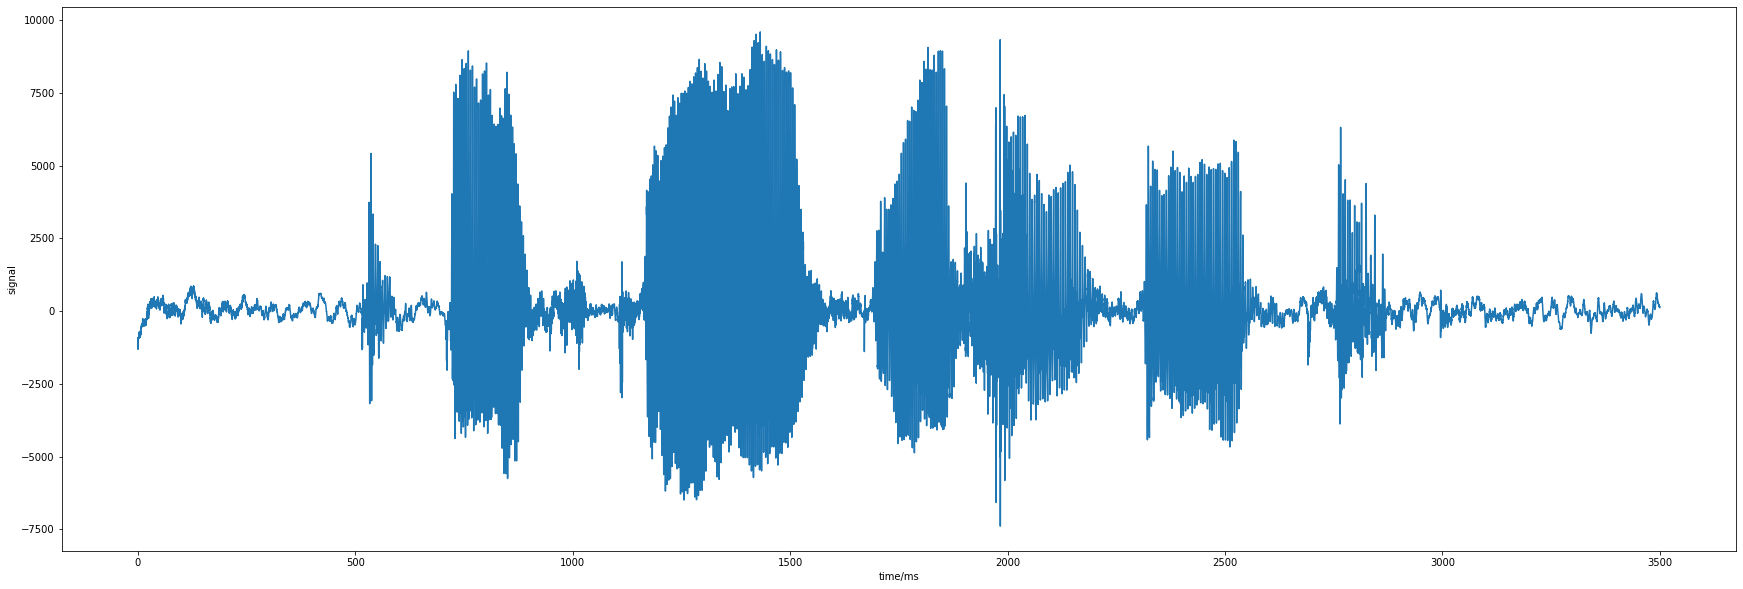

In [16]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('data/OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

x = np.arange(0, len(signal))
x = x/sample_rate*1000

# 绘图
figure, axe = plt.subplots(1, 1)
axe.plot(x, signal)
axe.set_xlabel("time/ms")
axe.set_ylabel("signal")
figure.set_size_inches(30, 10)   # 宽，高
#axe.set_title("幂函数")
plt.show()

## Pre-Emphasis
The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies.
提高高频的振幅

1. balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies
2. avoid numerical problems during the Fourier transform operation
3. may also improve the Signal-to-Noise Ratio (SNR)

$$
y(t) = x(t) - \alpha x(t-1)
$$

其中 $\alpha$ 值取0.95或者0.97

当前系统中，Pre-Emphasis的作用不大，1和3可以通过mean normalization方式达到同样效果，作用2，当前傅里叶转换程序已经基本没有numerical problems了

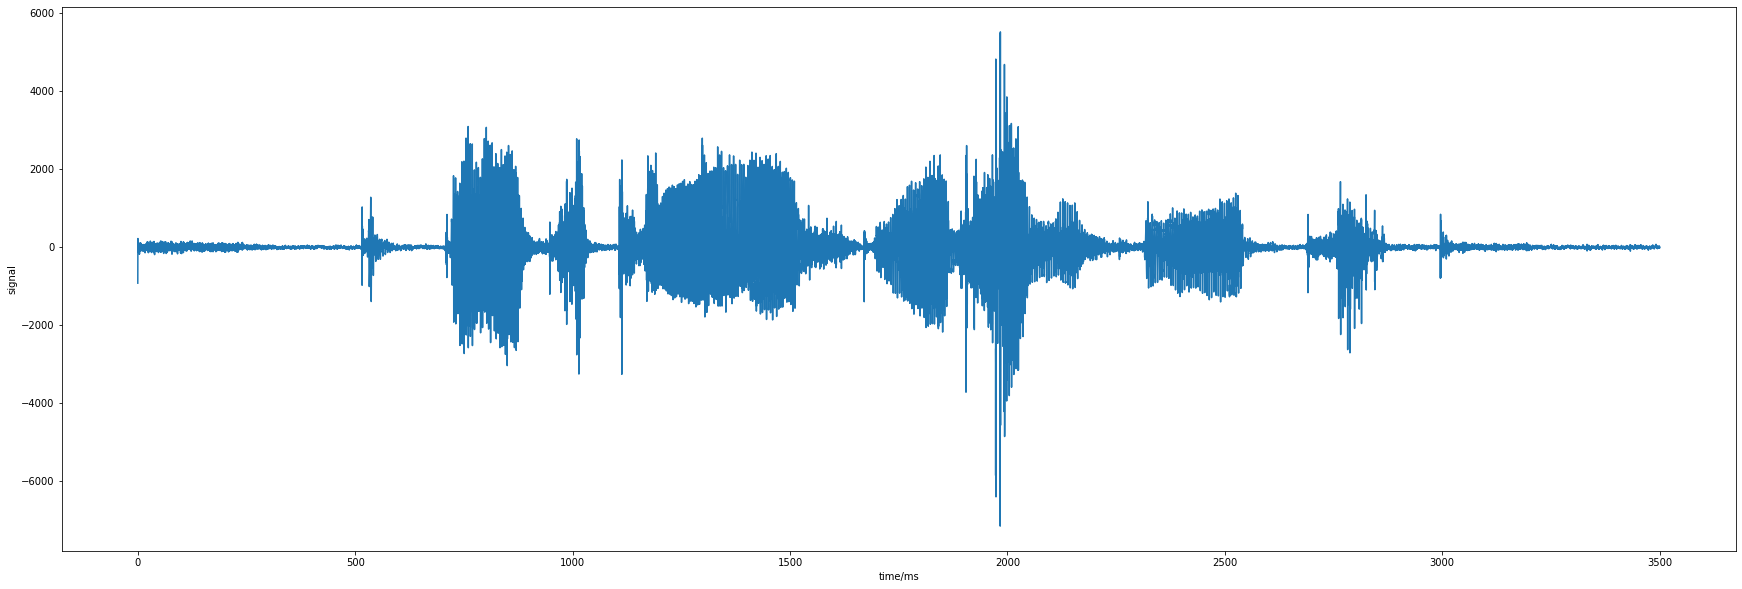

In [19]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

figure, axe = plt.subplots(1, 1)
axe.plot(x, emphasized_signal)
axe.set_xlabel("time/ms")
axe.set_ylabel("signal")
figure.set_size_inches(30, 10)   # 宽，高
#axe.set_title("幂函数")
plt.show()

## Framing
After pre-emphasis, we need to split the signal into short-time frames. 

背后原理：
对于整个时间跨度上的信号做傅里叶变化，无意义。因为内在频率随着时间是在变化的。
但可以合理假设，在一个较短的时间窗口内，这段信号的内在频率保持恒定。

一个帧的时长大约为 20~40ms，帧与帧之间有 50%(+/-10%)的重叠

这里设置帧长为25ms，10ms的步长(stride)，重叠部分为15ms

In [23]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))   # 最后一帧pad，补足长度
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

print(frames.shape)  # 348帧，每帧200个采样数据点
print(sample_rate)
print(num_frames)
print(z)

(348, 200)
8000
348
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Window
We apply a window function such as the Hamming window to each frame.

hamming窗函数

$$
w[n] = 0.54 - 0.46\cos\frac{2\pi n}{N-1}
$$

这里 $N = 200$，$0\le n\le N-1$

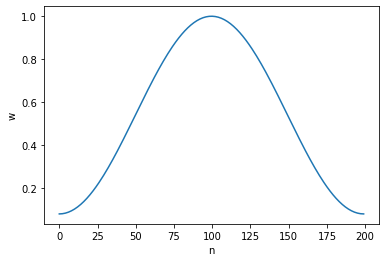

In [34]:
N = 200
n = np.arange(0, N, 1)
w = 0.54 - 0.46*np.cos(2*math.pi *n/(N-1))
#print(n)
#print(w)

figure, axe = plt.subplots(1, 1)
axe.plot(n, w)
axe.set_xlabel("n")
axe.set_ylabel("w")
#figure.set_size_inches(30, 10)   # 宽，高
#axe.set_title("幂函数")
plt.show()

frames *= numpy.hamming(frame_length)
#frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))

## Fourier-Transform and Power Spectrum
We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT)

其中 N 通常为 256 和 512。选取前256个频率或者512个频率

然后计算 power spectrum
$$
P = \frac{|FFT(x_i)|^2}{N}
$$

其中 $x_i$ 代表第 $i$ 帧

另一种角度，时域信号为 $s(n)$，离散情况下第 $i$ 帧的信号为 $s_i(n)$，其中 $0 \le n \lt 200$
经过离散傅里叶变换后的结果为 $S_i(k)$，最终的能量谱结果为 $P_i(k)$

$$
S_i(k) = \sum_{n=1}^Ns_i(n)h(n)e^{-j2\pi kn/N}  \quad\quad 0\le k \lt K
$$

其中 $h(n)$ 为Hamming窗函数

$$
P_i(k) = \frac{1}{N}\vert S_i(k) \vert^2
$$

We would generally perform a 512 point FFT and keep only the first 257 coefficents.
如果取 256point，最后结果取 129

In [43]:
NFFT = 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
print(frames.shape)
print(mag_frames.shape)
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
print(pow_frames.shape)  # shape 变换挺奇怪的

(348, 200)
(348, 129)
(348, 129)


## Filter Banks
滤波器组

首先将power spectrue 转换到梅尔刻度上(Me-scale)
然后通常应用40个三角滤波器(triangular filters)

The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies.

频率(f)和 梅尔刻度 (m) 之间的转换关系如下
$$
\begin{aligned}
m &= 2595\log_{10}\left(1 + \frac{f}{700}\right) \\
f &= 700(10^{m/2595} - 1)
\end{aligned}
$$

四十个三角滤波器如下
$$
H_m(k) = \left\{\begin{aligned}
0 \quad &k < f(m-1) \\
\frac{k - f(m-1)}{f(m) - f(m-1)} &\quad f(m-1)\le k < f(m) \\
1 \quad &k = f(m) \\
\frac{f(m+1)-k}{f(m+1)-f(m)} \quad &f(m)\lt k \le f(m+1) \\
0 \quad &k>f(m+1)
\end{aligned}
\right.
$$
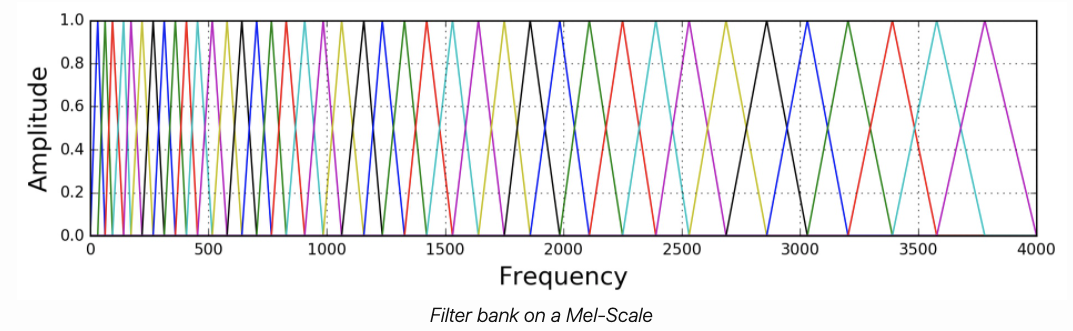

四十个三角滤波器，在Mel刻度上是等距的，在f刻度上则不是等距的，如上图所示。

注意我们是8k采用，所以最高频率取到了4k

In [47]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel  high: sample_rage/2
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)  # ((NFFT+1)/2)*hz_points/(sample_rate/2)  计算所映射的 power Spectrum 的ID
print(mel_points)
print(hz_points)
print(bin)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
print(filter_banks.shape)   # 248帧，每帧40维的特征

[   0.           52.34303726  104.68607451  157.02911177  209.37214902
  261.71518628  314.05822354  366.40126079  418.74429805  471.08733531
  523.43037256  575.77340982  628.11644707  680.45948433  732.80252159
  785.14555884  837.4885961   889.83163336  942.17467061  994.51770787
 1046.86074512 1099.20378238 1151.54681964 1203.88985689 1256.23289415
 1308.57593141 1360.91896866 1413.26200592 1465.60504317 1517.94808043
 1570.29111769 1622.63415494 1674.9771922  1727.32022946 1779.66326671
 1832.00630397 1884.34934122 1936.69237848 1989.03541574 2041.37845299
 2093.72149025 2146.06452751]
[   0.           33.27818895   68.13843198  104.65594038  142.90950098
  182.98164618  224.95883198  268.93162452  314.99489549  363.2480268
  413.79512499  466.74524587  522.2126298   580.31694812  641.18356143
  704.94378996  771.73519696  841.70188548  914.99480927  991.77209843
 1072.19940064 1156.45023851 1244.70638395 1337.15825037 1434.00530347
 1535.45649162 1641.73069664 1753.05720605 1869.

filter banks 结果如下
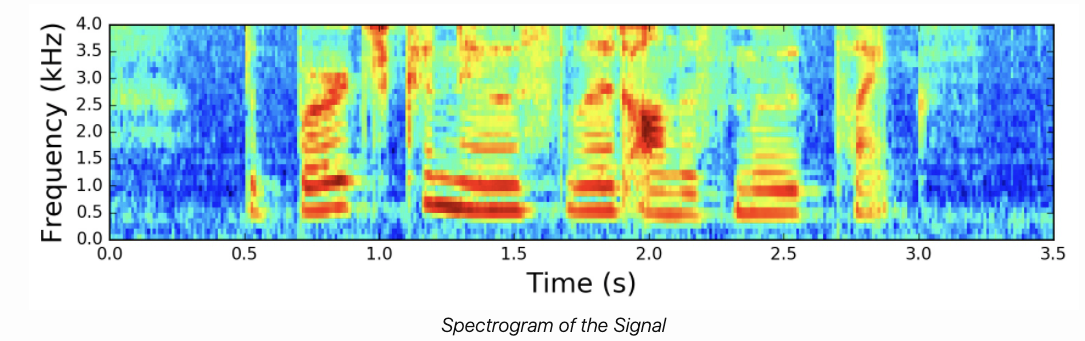

英文描述的比较好，直接摘录原文了

It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms.   
Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks.  
Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded;  
The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [49]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
print(mfcc.shape)

(348, 12)


## Mean Normalization
简而言之，就是每个分量减去平均值

In [ ]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)  # FBanks特征 Mean Normalization

mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)   # MFCC 特征 Mean Normalization


## Filter Banks vs MFCCs
原文摘录如下

To this point, the steps to compute filter banks and MFCCs were discussed in terms of their motivations and implementations. It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the speech signal and the human perception of such signals. On the contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some machine learning algorithms. The Discrete Cosine Transform (DCT) was needed to decorrelate filter bank coefficients, a process also referred to as whitening. In particular, MFCCs were very popular when Gaussian Mixture Models - Hidden Markov Models (GMMs-HMMs) were very popular and together, MFCCs and GMMs-HMMs co-evolved to be the standard way of doing Automatic Speech Recognition (ASR)2. With the advent of Deep Learning in speech systems, one might question if MFCCs are still the right choice given that deep neural networks are less susceptible to highly correlated input and therefore the Discrete Cosine Transform (DCT) is no longer a necessary step. It is beneficial to note that Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

It is sensible to question if the Fourier Transform is a necessary operation. Given that the Fourier Transform itself is also a linear operation, it might be beneficial to ignore it and attempt to learn directly from the signal in the time domain. Indeed, some recent work has already attempted this and positive results were reported. However, the Fourier transform operation is a difficult operation to learn and may arguably increase the amount of data and model complexity needed to achieve the same performance. Moreover, in doing Short-Time Fourier Transform (STFT), we’ve assumed the signal to be stationary within this short time and therefore the linearity of the Fourier transform would not pose a critical problem.